In [1]:
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict
from sortedcollections import OrderedSet

In [2]:
# u = 'w'
# V = OrderedSet(sorted('wxyz'))
# edges = {
#     ('w', 'x'): 1,
#     ('w', 'y'): 2,
#     ('x', 'z'): 2,
#     ('y', 'z'): 1,
# }

# u = 'a'
# V = OrderedSet(sorted('abcde'))
# edges = {
#     ('a', 'b'): 2,
#     ('a', 'c'): 1,
#     ('b', 'e'): 1,
#     ('b', 'd'): 4,
#     ('d', 'c'): 8,
#     ('c', 'e'): 6,
#     ('d', 'e'): 1
# }

# u = 'u'
# V = OrderedSet(sorted('uvwxyz'))
# edges = {
#     ('u', 'w'): 5,
#     ('u', 'v'): 2,
#     ('u', 'x'): 1,
#     ('v', 'x'): 2,
#     ('v', 'w'): 3,
#     ('x', 'w'): 3,
#     ('x', 'y'): 1,
#     ('w', 'z'): 5,
#     ('w', 'y'): 1,
#     ('y', 'z'): 2,
# }

u = 'u'
V = OrderedSet(sorted('uvwxyz'))
edges = {
    ('u', 'w'): 3,
    ('u', 'v'): 7,
    ('u', 'x'): 5,
    ('v', 'y'): 4,
    ('v', 'w'): 3,
    ('x', 'w'): 4,
    ('x', 'y'): 7,
    ('w', 'y'): 8,
    ('x', 'z'): 9,
    ('y', 'z'): 2,
}

In [3]:
class BiDict(OrderedDict):
    """https://stackoverflow.com/questions/1456373/two-way-reverse-map"""
    def __setitem__(self, key: tuple, value):
        if key in self:
            del self[key]

        OrderedDict.__setitem__(self, key, value)
        OrderedDict.__setitem__(self, key[::-1], value)
        
    def __delitem__(self, key):
        OrderedDict.__delitem__(self, key)
        OrderedDict.__delitem__(self, key[::-1])

# _____________________________________________________________________________________________

class Node:
    def __init__(self, value, dist=0, prev=None):
        self.value = value
        self.dist = dist
        self.prev = prev  # predecessor node along path from source to self

    def __repr__(self):
        return self.value

    def __str__(self):
        return f"{self.dist},{self.prev!r}" if self.dist != np.inf else str(np.inf)

    def __getitem__(self, q):
        """Returns the dist from p to q if neighbors; otherwise, infinity"""
        return lookup[self][q]

    @property
    def neighbors(self):
        return OrderedSet(filter(lambda u: (self.value, u.value) in E, G))

# _____________________________________________________________________________________________

def check(path):
    """Checks if a tree is acyclic and connected"""
    G = {n: set(v for u, v in path if u == n) for n in V}

    def dfs(source):
        stack, visited = list(source), set()
        while stack:
            visited.add(n := stack.pop())
            stack.extend(G[n])
            if any(n in visited for n in stack):
                raise Exception('cycle found')
        if visited != V:
            raise Exception(f'nodes {V - visited} were not connected')

    try:
        dfs(u)
    except Exception as e:
        print(e)

In [4]:
E = BiDict(**edges)

init = Node(value=u)
init.prev = init

graph = OrderedSet(map(lambda v: Node(value=v, dist=E.get((u, v), np.inf), prev=init), V - set(u)))
visited = OrderedSet({init})

G = visited | graph

path = set()

In [5]:
lookup = OrderedDict({
    u: OrderedDict({
        v: E.get((u.value, v.value), np.inf)
        for v in G-{u}})
    for u in G
})

lookup

OrderedDict([(u, OrderedDict([(v, 7), (w, 3), (x, 5), (y, inf), (z, inf)])),
             (v, OrderedDict([(u, 7), (w, 3), (x, inf), (y, 4), (z, inf)])),
             (w, OrderedDict([(u, 3), (v, 3), (x, 4), (y, 8), (z, inf)])),
             (x, OrderedDict([(u, 5), (v, inf), (w, 4), (y, 7), (z, 9)])),
             (y, OrderedDict([(u, inf), (v, 4), (w, 8), (x, 7), (z, 2)])),
             (z, OrderedDict([(u, inf), (v, inf), (w, inf), (x, 9), (y, 2)]))])

In [6]:
headers = [(f"D({v!r}),p({v!r})", [str(v)]) for v in graph]
table = OrderedDict([("N'", [u]), *headers])

table

OrderedDict([("N'", ['u']),
             ('D(v),p(v)', ['7,u']),
             ('D(w),p(w)', ['3,u']),
             ('D(x),p(x)', ['5,u']),
             ('D(y),p(y)', ['inf']),
             ('D(z),p(z)', ['inf'])])

In [7]:
for _ in range(1, len(V)):
    # NOTE: Python's min() function always selects the first occurrence if dist are equal
    # Therefore, priority is based on ASCII values of a node
    p = min(graph-visited, key=lambda u: u.dist)

    visited.add(p)
    path.add((p.prev.value, p.value))
    
    table["N'"].append(''.join(map(repr, visited)))
    print(f"===NODE {p!r}===")

    for q in p.neighbors-visited:
        print(f"D({q!r}) = min(D({q!r}), D({p!r}) + C({p!r}, {q!r})) =",
              f"min({q.dist}, {p.dist} + {p[q]}) =",
              f"min({q.dist}, {p.dist + p[q]}) =",
              min(q.dist, p.dist + p[q]))

        # NOTE: if the algorithm finds another path from p to q with the same dist/cost,
        # it will change paths/routes (aka, change parents)
        if p.dist + p[q] <= q.dist:
            q.dist = p.dist + p[q]
            q.prev = p

        table[f"D({q!r}),p({q!r})"].append(str(q))

    for q in graph-visited-p.neighbors:  # unreachable and unvisited nodes from p
        table[f"D({q!r}),p({q!r})"].append(str(q))

===NODE w===
D(v) = min(D(v), D(w) + C(w, v)) = min(7, 3 + 3) = min(7, 6) = 6
D(x) = min(D(x), D(w) + C(w, x)) = min(5, 3 + 4) = min(5, 7) = 5
D(y) = min(D(y), D(w) + C(w, y)) = min(inf, 3 + 8) = min(inf, 11) = 11
===NODE x===
D(y) = min(D(y), D(x) + C(x, y)) = min(11, 5 + 7) = min(11, 12) = 11
D(z) = min(D(z), D(x) + C(x, z)) = min(inf, 5 + 9) = min(inf, 14) = 14
===NODE v===
D(y) = min(D(y), D(v) + C(v, y)) = min(11, 6 + 4) = min(11, 10) = 10
===NODE y===
D(z) = min(D(z), D(y) + C(y, z)) = min(14, 10 + 2) = min(14, 12) = 12
===NODE z===


In [8]:
for entry in table.values():
    entry.extend(['---'] * (len(V) - len(entry)))

In [9]:
check(path)

In [10]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'     │ D(v),p(v)   │ D(w),p(w)   │ D(x),p(x)   │ D(y),p(y)   │ D(z),p(z)   │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ u      │ 7,u         │ 3,u         │ 5,u         │ inf         │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ uw     │ 6,w         │ ---         │ 5,u         │ 11,w        │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ uwx    │ 6,w         │ ---         │ ---         │ 11,w        │ 14,x        │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ uwxv   │ ---         │ ---         │ ---         │ 10,v        │ 14,x        │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  4 │ uwxvy  │ ---         │ ---         │ ---       

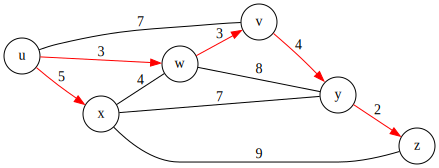

In [11]:
sptree = graphviz.Graph("Dijkstra's Link State Algorithm",
                        filename='spanning_tree',
                        graph_attr={'rankdir': 'LR'},
                        node_attr={'shape': 'circle'})

[sptree.node(v) for v in V]
[sptree.edge(u, v, dir='forward', label=str(E[(u, v)]), color="Red") for u, v in path]
[sptree.edge(u, v, label=str(E[(u, v)])) for (u, v) in edges if {u, v} not in map(set, path)]

sptree